In [2]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
import xgboost
import lightgbm
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

df = load_df()

In [3]:
mask = df['naive_strategy_action'] | df['target_two_sided_ptu_alt']

df = df[mask].reset_index()

In [4]:
def custom_scorer(estimator, X, y):
    try:
        return f1_score(y, estimator.predict(X))
    except Exception as e:
        print(f"Error during scoring: {e}")
        return np.nan

def train(features: pd.DataFrame, target: pd.DataFrame, model, params={}, splits=10):
    """Train a model with grid search"""
    cv = TimeSeriesSplit(n_splits=splits)

    model = GridSearchCV(estimator=model, param_grid=params, scoring='f1',
                         refit=True, cv=cv.split(features), n_jobs=-1, verbose=1)
    model.fit(features, target)
    best_model = model.best_estimator_
    print(model.best_params_)
    train_predictions = best_model.predict(features)

    return np.array(train_predictions), best_model

In [5]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "upward_dispatch_published",
    "downward_dispatch_published",
    'min_ptu_price_known',
    "max_ptu_price_known",
    "settlement_price_bestguess",
    'naive_strategy_action',
    'PTU',
    'forecast_wind',
    'forecast_solar',
    'forecast_demand',
    'target_two_sided_ptu_realtime',
]

splits = get_splits(df, features=features, return_dict_pair=False)

train_x = splits['train'][0]
train_y = splits['train'][1]

valid_x = splits['valid'][0]
valid_y = splits['valid'][1]
valid_df = splits['valid'][3]


test_x = splits['test'][0]
test_y = splits['test'][1]
test_df = splits['test'][3]

# train_x = df[features][:165195]
# train_y = df['target_two_sided_ptu'][:165195]

# test_x = df[features][165195:]
# test_y = df['target_two_sided_ptu'][165195:]
# ids = df['ptu_id'][165195:]



Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}


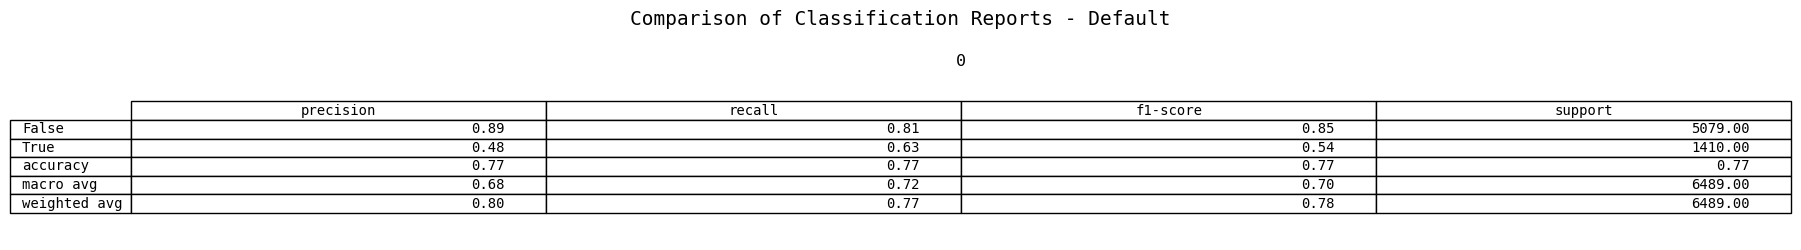

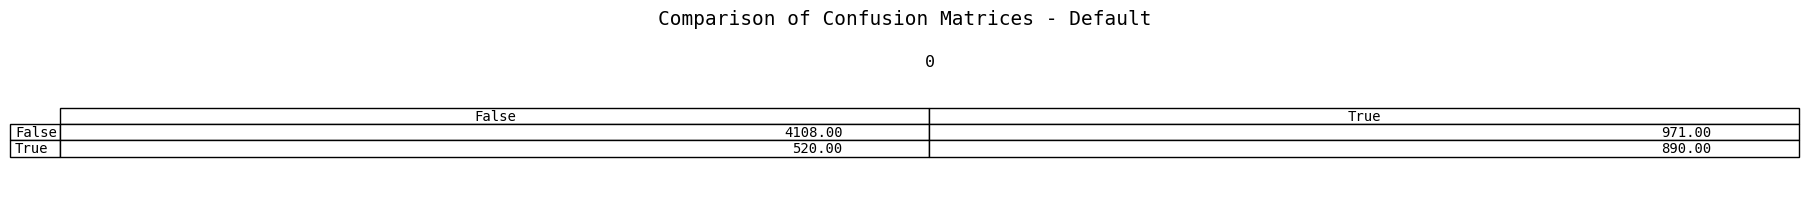

In [12]:
# Initialize the Decision Tree Classifier
# clf = HistGradientBoostingClassifier()

# # Train the classifier
# clf.fit(train_x, train_y)

# y_pred = clf.predict(test_x)

pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('svr', HistGradientBoostingClassifier())
])



_, model = train(train_x, train_y, pipe, {}, 5)
# pipe.fit(train_x, train_y)
# save_model(pipe, 'xgboost', 'subsample')
y_pred = model.predict(valid_x)

show_basic_metrics(valid_df, y_pred, False)